In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

### Research Question: 
Based on visualization of light and motion, we see that light and motion are heavily correlated for sensor 2. As a result, if we wanted to put automated lights in this apartment, the sensor could do a good job of predicting when the light should be on of off, based on factors such as motion, temperature, humidity, scheduling (psets due), etc. This could be useful for light conservation.

In [2]:
df = pd.read_csv("all_data.csv").drop(columns=['Unnamed: 0'])

In [3]:
# create outcome variable
sleep_scores = []
for i in range(df.shape[0]):
    if (df.loc[i,'num_hrs_slept'] >= 7):
        sleep_scores.append(1)
    else:
        sleep_scores.append(0)

# create interaction and polynomial terms
df['sleep_score'] = sleep_scores
df['motion2'] = df['tot_motion_count']**2
df['light2'] = df['avg_hrly_light']**2
df['num_psets_due2'] = df['num_psets_due']**2
df['motion_X_light'] = df['tot_motion_count']*df['avg_hrly_light']
df['press_X_hum'] = df['avg_hrly_press']*df['avg_hrly_hum']
df['press_X_temp'] = df['avg_hrly_press']*df['avg_hrly_temp']
df['temp_X_hum'] = df['avg_hrly_temp']*df['avg_hrly_hum']
df['temp_X_hum_X_press'] = df['avg_hrly_temp']*df['avg_hrly_hum']*df['avg_hrly_press']
df['weekday_X_month'] = df['month']*df['weekday']
df['weekday_X_psets'] = df['num_psets_due']*df['weekday']
df.drop(columns=['num_hrs_slept', 'day','hour'], inplace=True)

# split into test and train
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df.sleep_score)
X_train = train_data.drop(columns=['sleep_score'])
y_train = train_data['sleep_score']
X_test = test_data.drop(columns=['sleep_score'])
y_test = test_data['sleep_score']

In [4]:
def standardize(train_df, val_df):
    # fit on train df
    scaler = StandardScaler(with_mean=False) # with mean=True also centers before scaling
    scaler.fit(train_df)
    
    # transform train
    train_scaled = scaler.transform(train_df)
    scaled_train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
    
    # transform val
    val_scaled = scaler.transform(val_df)
    scaled_val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
    
    return scaled_train_df, scaled_val_df #, scaled_test_df

def scale(X_train, X_test, y_train, y_test, cols_to_scale):
    X_train_pre = X_train[cols_to_scale]
    X_test_pre = X_test[cols_to_scale]
    X_train_scaled, X_test_scaled = standardize(X_train_pre, X_test_pre)
    
    X_train1 = X_train[X_train.columns.difference(cols_to_scale)]
    X_test1 = X_test[X_test.columns.difference(cols_to_scale)]
    
    X_train2 = pd.concat([X_train_scaled, X_train1], sort=False, axis=1)
    X_test2 = pd.concat([X_test_scaled, X_test1], sort=False, axis=1)
    return X_train2, X_test2

def compute_t_test(X_train, y_train):
    ttests = []
    p_vals = []
    for i,col in enumerate(X_train.columns):
        col_to_compare = X_train[col]
        # compare gene x's expression level for cancer 1 and cancer 2
        c0 = col_to_compare[y_train == 0]
        c1 = col_to_compare[y_train == 1]
        # equal_var=False gives Welch's
        ttest_val, p_val = scipy.stats.ttest_ind(c0, c1, axis=0) 
        ttests.append(ttest_val)
        p_vals.append(p_val)
    return ttests, p_vals

In [5]:
ttests, pvals = compute_t_test(X_train,y_train)
sorted_id = np.argsort(abs(np.array(pvals)))[:10] # sorts in ascending order

In [6]:
most_sig = pd.DataFrame({"Predictor": X_train.columns[sorted_id], "P values": np.array(pvals)[list(sorted_id)]})
most_sig

,Predictor,P values
0,avg_hrly_temp,0.000002
1,press_X_temp,0.000005
2,temp_X_hum,0.000105
3,temp_X_hum_X_press,0.000136
4,avg_hrly_hum,0.000705
5,press_X_hum,0.000963
6,motion2,0.004288
7,tot_motion_count,0.017736
8,num_psets_due,0.019747
9,avg_hrly_press,0.026213


### Linear and Logistic

In [7]:
# linear
# standardize
cols_to_scale = ['avg_hrly_hum', 'avg_hrly_light', 'avg_hrly_press', 'tot_motion_count', 'avg_hrly_temp','motion_X_light',
                 'press_X_hum','press_X_temp','temp_X_hum','temp_X_hum_X_press']

X_train2, X_test2 = scale(X_train, X_test, y_train, y_test, cols_to_scale)

model = LinearRegression().fit(X_train2, y_train) #['tot_motion_count'].values.reshape(-1,1)
print("Linear Regression train accuracy:", model.score(X_train2, y_train))
print("Linear Regression test accuracy:", model.score(X_test2, y_test))

# logistic
# standardize 
logreg_sleep = LogisticRegression(solver = 'lbfgs', max_iter=100000).fit(X_train2, y_train)
print("Logistic Regression train score:", logreg_sleep.score(X_train2, y_train))
print("Logistic Regression test score:",logreg_sleep.score(X_test2, y_test))

Linear Regression train accuracy: 0.2604621259856418
Linear Regression test accuracy: 0.2528055218642761
Logistic Regression train score: 0.6405228758169934
Logistic Regression test score: 0.6168831168831169


### Decision Tree (with cross validation)

In [28]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, X_test, y_test, depths):
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    for i in depths:
        # create model, cross validate
        tree_model = DecisionTreeClassifier(max_depth=i)
        score = cross_val_score(estimator=tree_model,X=X_train, y=y_train, cv=5, n_jobs=-1)
        cvmeans.append(score.mean())
        cvstds.append(score.std())
        
        # model training score
        tree_model.fit(X_train, y_train)
        train_score = tree_model.score(X_train,y_train)
        test_score = tree_model.score(X_test,y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    upper_ci = [cvmeans[i] + 2*cvstds[i] for i in range(len(depths))]
    lower_ci = [cvmeans[i] - 2*cvstds[i] for i in range(len(depths))]
    
    plt.plot(depths, cvmeans, "-.",label="CV Mean")
    plt.fill_between(depths, lower_ci, upper_ci, alpha=0.2, label="CV Mean 95% CI")
    plt.plot(depths,train_scores,label="Train Scores")
    plt.plot(depths,test_scores,label="Test Scores")
    plt.xlabel("Maximum Depth")
    plt.ylabel("Accuracy")
    plt.rcParams["figure.figsize"] = (15,10)
    plt.title("Variation of Accuracy with Simple Decision Tree Depth")
    plt.legend(loc='lower right')
    plt.show()  
    return cvmeans, cvstds, train_scores, test_scores

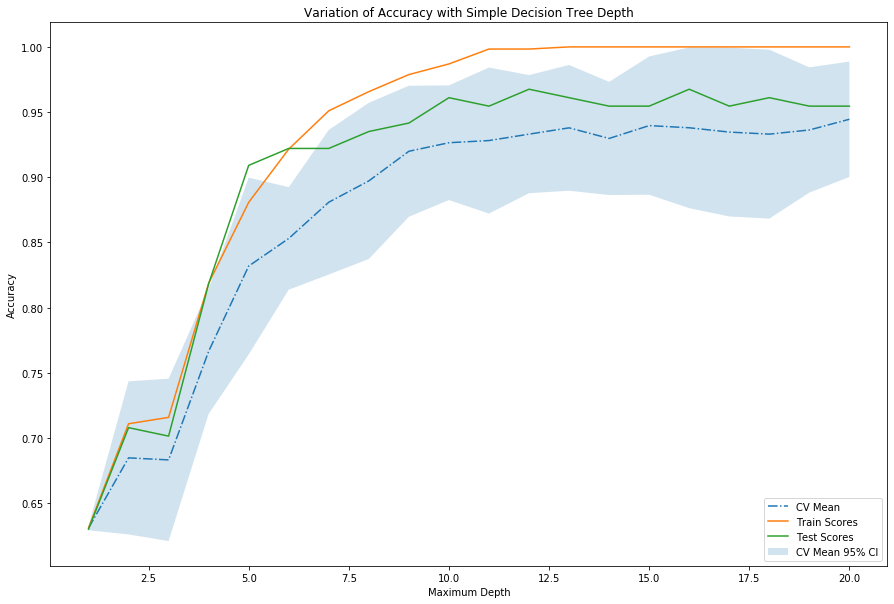

In [29]:
cvmeans, cvstds, train_scores, test_scores = calc_meanstd(X_train, y_train, X_test, y_test, depths)

In [30]:
best_depth = np.argsort(cvmeans)[::-1][0]
print("Thes best depth chosen by CV is {}.".format(best_depth))

# fit tree based on best cv depth
best_cv_tree = DecisionTreeClassifier(max_depth=best_depth)
best_cv_tree.fit(X_train,y_train)
best_cv_tree_train_score = best_cv_tree.score(X_train,y_train)
best_cv_tree_test_score = best_cv_tree.score(X_test,y_test)

print("Best tree depth train score: {}.".format(best_cv_tree_train_score))
print("Best tree depth test score: {}.".format(best_cv_tree_test_score))

Thes best depth chosen by CV is 19.
Best tree depth train score: 1.0.
Best tree depth test score: 0.9675324675324676.


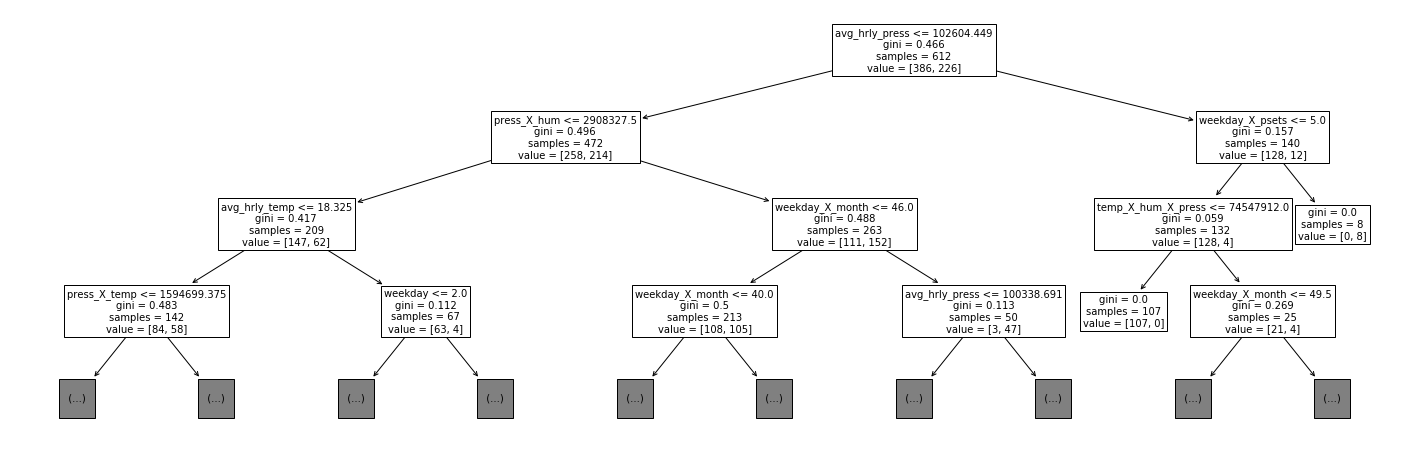

In [31]:
plt.subplots(figsize = (25,8))
tree.plot_tree(best_cv_tree, feature_names = X_train.columns, max_depth=3, fontsize = 10) 
plt.show()

### Overfit Decision Tree 

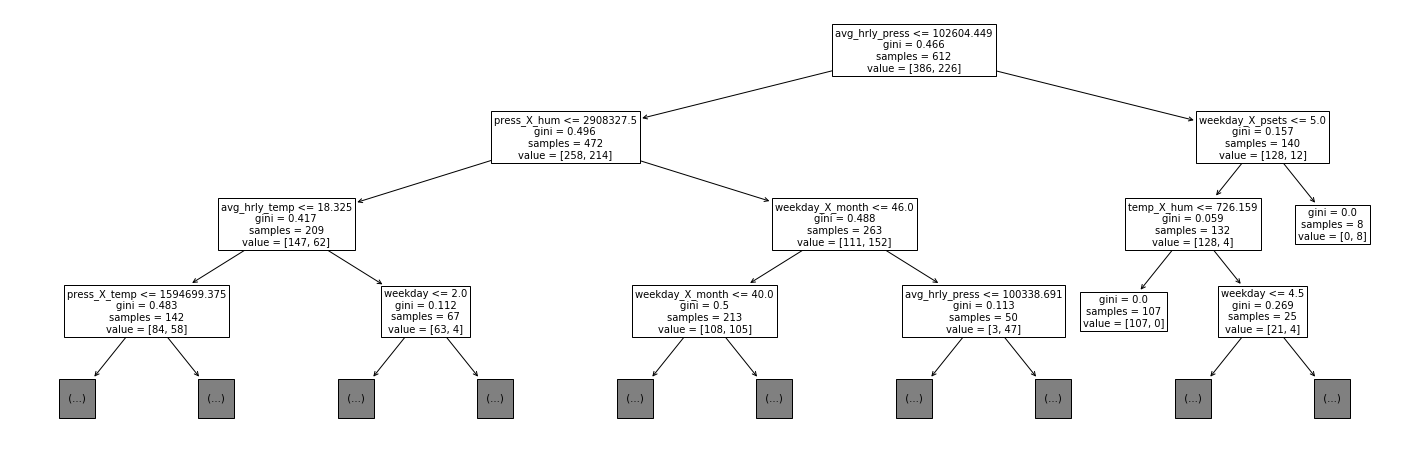

In [32]:
# picked 20 because CV is based on range of up to 20 trees
tree_depth = 20
full_train_model = DecisionTreeClassifier(max_depth=tree_depth)
full_train_model.fit(X_train, y_train)
full_model_train_score = accuracy_score(full_train_model.predict(X_train), y_train)
full_model_test_score = accuracy_score(full_train_model.predict(X_test), y_test)

plt.subplots(figsize = (25,8))
tree.plot_tree(full_train_model, feature_names = X_train.columns, max_depth=3, fontsize = 10) 
plt.show()

### Bagging with simple decision trees

In [33]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    train_preds = np.zeros((train_data.shape[0], n_trees))
    test_preds = np.zeros((test_data.shape[0], n_trees))
    bagging_models = []
    
    for i in range(n_trees):
        # sample data
        sample = train_data.sample(frac=.8, replace=True)
        response_var = sample["sleep_score"]
        sample = sample.drop(["sleep_score"], axis=1)
#         print(sample.shape,response_var.shape)
        
        # fit tree
        model_tree = DecisionTreeClassifier(max_depth=tree_depth)
        model_tree.fit(sample, response_var)
        train_preds[:,i] = model_tree.predict(X_train)
        test_preds[:,i] = model_tree.predict(X_test)
        bagging_models.append(model_tree)
        
    # save dataframes
    cols = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
    bagging_train = pd.DataFrame(train_preds, columns=cols)
    bagging_test = pd.DataFrame(test_preds, columns=cols)
    
    return bagging_train, bagging_test, bagging_models

In [34]:
n_trees = 55
tree_depth = 20
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth, random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

,Bootstrap-Model_1,Bootstrap-Model_2,Bootstrap-Model_3,Bootstrap-Model_4,Bootstrap-Model_5,Bootstrap-Model_6,Bootstrap-Model_7,Bootstrap-Model_8,Bootstrap-Model_9,Bootstrap-Model_10,...,Bootstrap-Model_46,Bootstrap-Model_47,Bootstrap-Model_48,Bootstrap-Model_49,Bootstrap-Model_50,Bootstrap-Model_51,Bootstrap-Model_52,Bootstrap-Model_53,Bootstrap-Model_54,Bootstrap-Model_55
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Bootstrap-Model_1,Bootstrap-Model_2,Bootstrap-Model_3,Bootstrap-Model_4,Bootstrap-Model_5,Bootstrap-Model_6,Bootstrap-Model_7,Bootstrap-Model_8,Bootstrap-Model_9,Bootstrap-Model_10,...,Bootstrap-Model_46,Bootstrap-Model_47,Bootstrap-Model_48,Bootstrap-Model_49,Bootstrap-Model_50,Bootstrap-Model_51,Bootstrap-Model_52,Bootstrap-Model_53,Bootstrap-Model_54,Bootstrap-Model_55
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [35]:
train_pred = []
test_pred = []

for i in range(bagging_train_df.shape[0]):
    num_zeros_train = bagging_train_df.iloc[i,:][bagging_train_df.iloc[i,:]==0].shape[0]
    num_ones_train = bagging_train_df.iloc[i,:][bagging_train_df.iloc[i,:]==1].shape[0]

    if num_ones_train > num_zeros_train:
        train_pred.append(1)
    else:
        train_pred.append(0)

for i in range(bagging_test_df.shape[0]):
    num_zeros_test = bagging_test_df.iloc[i,:][bagging_test_df.iloc[i,:]==0].shape[0]
    num_ones_test = bagging_test_df.iloc[i,:][bagging_test_df.iloc[i,:]==1].shape[0]

    if num_ones_test > num_zeros_test:
        test_pred.append(1)
    else:
        test_pred.append(0)

In [36]:
bagging_accuracy_train = accuracy_score(train_pred, y_train)
print("Bagging train accuracy {}.".format(bagging_accuracy_train))
bagging_accuracy_test = accuracy_score(test_pred, y_test)
print("Bagging test accuracy {}.".format(bagging_accuracy_test))

Bagging train accuracy 1.0.
Bagging test accuracy 0.987012987012987.


In [37]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [38]:
# convert to arrays
bagging_train_array = bagging_train_df.values
bagging_test_array = bagging_test_df.values

# find running predictions
train_accuracies = running_predictions(bagging_train_array, y_train.values)
test_accuracies = running_predictions(bagging_test_array, y_test.values)

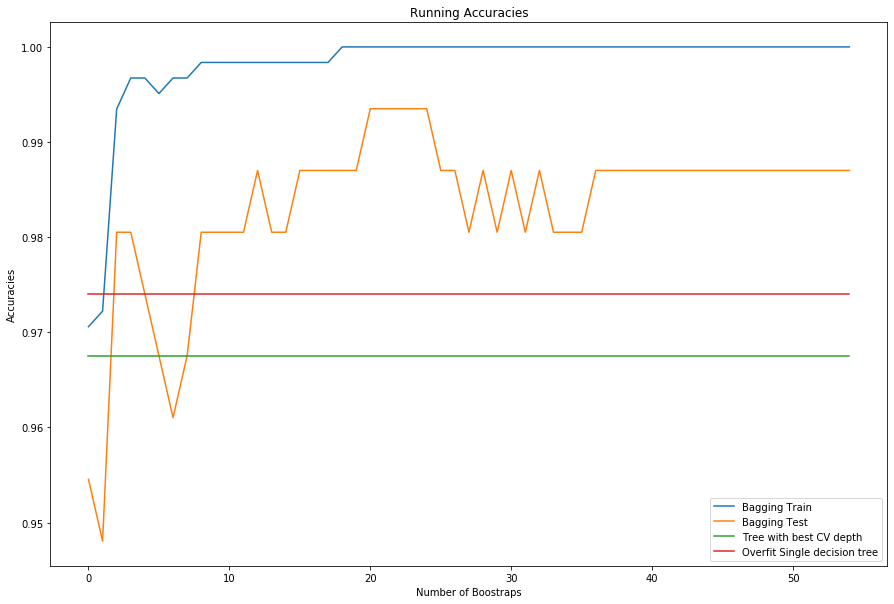

In [39]:
n_trees=55
plt.plot(np.arange(n_trees), train_accuracies, label="Bagging Train")
plt.plot(np.arange(n_trees), test_accuracies, label="Bagging Test")
plt.plot(np.arange(n_trees),best_cv_tree_test_score*np.ones(n_trees), label="Tree with best CV depth")
plt.plot(np.arange(n_trees),full_model_test_score*np.ones(n_trees), label="Overfit Single decision tree")
plt.title("Running Accuracies")
plt.xlabel("Number of Boostraps")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

In [40]:
bagging_models_first_nodes = []
for model in bagging_models:
#     print(model.tree_.feature[0])
    bagging_models_first_nodes.append(model.tree_.feature[0])

In [41]:
ids, counts = np.unique(bagging_models_first_nodes, return_counts=True)

top_predictors_bagging = pd.DataFrame({"Top Predictor": X_train.columns[ids], "Counts": counts})
top_predictors_bagging.sort_values(by=["Counts"], ascending=False)

,Top Predictor,Counts
1,avg_hrly_press,47
0,avg_hrly_temp,5
2,press_X_hum,2
3,weekday_X_psets,1


### Random Forest Classifier

In [42]:
n_trees = 55
tree_depth = 20
rf_model = RandomForestClassifier(n_estimators = n_trees, max_depth= tree_depth)
rf_model.fit(X_train, y_train)
rf_y_pred_train = rf_model.predict(X_train)
rf_y_pred_test = rf_model.predict(X_test)

random_forest_train_score = accuracy_score(y_train, rf_y_pred_train)
random_forest_test_score = accuracy_score(y_test, rf_y_pred_test)

In [43]:
rf_models_first_nodes = []
top_predictors = []

for m in rf_model.estimators_:
    rf_models_first_nodes.append(m.tree_.feature[0])
    top_predictors.append(X_train.columns[rf_models_first_nodes])

    
feats, counts = np.unique(rf_models_first_nodes, return_counts=True)
top_predictors_rf = pd.DataFrame({"Top Predictor": X_train.columns[feats], "Counts": counts})
top_predictors_rf.sort_values(by=["Counts"], ascending=False)

,Top Predictor,Counts
4,avg_hrly_press,11
3,avg_hrly_temp,8
9,press_X_temp,8
11,temp_X_hum_X_press,6
12,weekday_X_psets,5
2,avg_hrly_hum,4
1,weekday,3
8,press_X_hum,3
10,temp_X_hum,3
0,month,1


In [44]:
classifiers = ['single tree with best depth chosen by CV', 'single depth-X tree', 'bagging 55 depth-X trees', 'Random Forest of 55 depth-X trees']
training_accuracies = [best_cv_tree_train_score, full_model_train_score, np.mean(train_accuracies), random_forest_train_score]
testing_accuracies = [best_cv_tree_test_score, full_model_test_score, np.mean(test_accuracies), random_forest_test_score]

results_df = pd.DataFrame({'classifier': classifiers, 'training accuracy': training_accuracies, 'test accuracy': testing_accuracies})

In [45]:
results_df

,classifier,training accuracy,test accuracy
0,single tree with best depth chosen by CV,1.000000,0.967532
1,single depth-X tree,1.000000,0.974026
2,bagging 55 depth-X trees,0.998217,0.983235
3,Random Forest of 55 depth-X trees,1.000000,0.993506
